In [1]:
##EXAMPLE 1 from powerpoint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
import os #to get paths
import matplotlib.pyplot as plt #import matplotlib #draw graphs
import numpy as np #data processing
import pandas as pd #data processing

from parmed.amber import AmberParm, AmberMask

import pytraj as pt #trajectory analysis
import shutil #utilities like copy file

qmmask = ":248|:177@CD,OE1,OE2,CG,HG1,HG2"
rms_mask = "rms_mask = '!:WAT,POT,CLA,248'"
QMMM_method = 'DFTB3'

FOLDER_PA = "0_Parent_example"
FOLDER_EQ = "1_Equilibrate_example"
FOLDER_ST = "2_String_example"

N_REPLICATES = 16
N_REPLICATES_ST = 32

# os.mkdir(FOLDER_EQ)
# os.mkdir(FOLDER_ST)
# os.mkdir(FOLDER_PA)

STRUCTURES=["1A0_6NB_GS", "1A0_6NB_TS", "1A5_6NB_GS", "1A5_6NB_TS"]

In [ ]:
# generating input files - parametrising system with AMBER

for STRUCTURE in STRUCTURES:  
    BOX = "10"
    with open("tleap.in", "w") as f:
        f.write(f"""source leaprc.protein.ff19SB 
source leaprc.gaff
source leaprc.water.tip3p
loadamberprep   {FOLDER_PA}/6NBI.prepi
loadamberparams {FOLDER_PA}/6NBI.frcmod
mol = loadpdb {FOLDER_PA}/{STRUCTURE}_parent.pdb
#addIons2 mol Cl- 0
solvateOct mol TIP3PBOX {BOX}
addIonsRand mol Cl- 23 K+ 22 5
saveamberparm mol {FOLDER_PA}/{STRUCTURE}.parm7 {FOLDER_PA}/{STRUCTURE}.rst7
quit
""")
    
    os.system("tleap -s -f tleap.in #> tleap.out")
    
    #'!' works in the same way as os.system, it executes the line as a shell command
    !ambpdb  -p "$FOLDER_PA"/"$STRUCTURE".parm7 \
             < "$FOLDER_PA"/"$STRUCTURE".rst7 \
             > "$FOLDER_PA"/"$STRUCTURE".pdb


In [85]:
#restraints values for natchem files

## values from extended data fig 2 (https://doi.org/10.1038/s41557-021-00763-6) apart from ligbase dihed. Fig. 2 has this centred around 0, should be 180
RESTRAINTS={}
RESTRAINTS["CO_dist"] = {}
RESTRAINTS["CO_dist"]["masks"] = ":248@C15 :177@OE2"
RESTRAINTS["CO_dist"]["r1"] = 0
RESTRAINTS["CO_dist"]["r2"] = 3.5
RESTRAINTS["CO_dist"]["r3"] = 3.5
RESTRAINTS["CO_dist"]["r4"] = 100
RESTRAINTS["CO_dist"]["rk2"] = 0
RESTRAINTS["CO_dist"]["rk3"] = 5

RESTRAINTS["TRP_dihed"] = {}
RESTRAINTS["TRP_dihed"]["masks"] = ":209@CA :209@CB :209@CG :209@CD2"
RESTRAINTS["TRP_dihed"]["r1"] = -70
RESTRAINTS["TRP_dihed"]["r2"] = 65
RESTRAINTS["TRP_dihed"]["r3"] = 155
RESTRAINTS["TRP_dihed"]["r4"] = 290
RESTRAINTS["TRP_dihed"]["rk2"] = 10
RESTRAINTS["TRP_dihed"]["rk3"] = 10

RESTRAINTS["ligbase_dihed"] = {}
RESTRAINTS["ligbase_dihed"]["masks"] = ":177@OE2 :248@C15 :248@N14 :248@O16"
RESTRAINTS["ligbase_dihed"]["r1"] = 60
RESTRAINTS["ligbase_dihed"]["r2"] = 120
RESTRAINTS["ligbase_dihed"]["r3"] = 240
RESTRAINTS["ligbase_dihed"]["r4"] = 300
RESTRAINTS["ligbase_dihed"]["rk2"] = 10
RESTRAINTS["ligbase_dihed"]["rk3"] = 10

In [88]:
##defines a function to write restraint files

def write_DISANG(RESTRAINTS, min=False):
    for structure in STRUCTURES:
        comment = []
        temp = [f"parm {FOLDER_PA}/{structure}.parm7"]
        for restraint in RESTRAINTS.keys():
            print(restraint)
            masks = RESTRAINTS[restraint]["masks"]
            _r1 = RESTRAINTS[restraint]["r1"]
            _r2 = RESTRAINTS[restraint]["r2"]
            _r3 = RESTRAINTS[restraint]["r3"]
            _r4 = RESTRAINTS[restraint]["r4"]
            if min == True:
                _rk2 = RESTRAINTS[restraint]["rk2"]*10
                _rk3 = RESTRAINTS[restraint]["rk3"]*10
                outfname = f"{FOLDER_PA}/{structure}_DISANG_min.rst"
            else:
                _rk2 = RESTRAINTS[restraint]["rk2"]
                _rk3 = RESTRAINTS[restraint]["rk3"]
                outfname = f"{FOLDER_PA}/{structure}_DISANG.rst"
            temp.append(f"rst {masks} r1 {_r1} r2 {_r2} r3 {_r3} r4 {_r4} rk2 {_rk2} rk3 {_rk3} out {outfname}")

            comment.append(f"#{masks} r1:{_r1} r2:{_r2} r3:{_r3} r4:{_r4} rk2:{_rk2} rk3:{_rk3}") ##this is printed in the .log file for reference, each line can only be 80 characters long
        
        comment_string = "\n".join(comment)
        temp.append("EOF")

        with open("cpptraj_rst.in", "w") as f:
            f.write("\n".join(temp))

        os.system("cpptraj -i cpptraj_rst.in")

        # comments need to be at the top of the .rst file to be read
        with open(f"{outfname}", "r+") as f:
            content = f.read()
            f.seek(0,0)
            f.write(f"{comment_string}\n{content}")

In [89]:
#specify parameters in cell above function definition - dictionary of values named RESTRAINTS
write_DISANG(RESTRAINTS)
#writes a specific disang file for minimisation - 10x force constant
write_DISANG(RESTRAINTS, min=True)

CO_dist
TRP_dihed
ligbase_dihed

CPPTRAJ: Trajectory Analysis. V4.25.6 (AmberTools V20.11)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 01/10/23 17:01:07
| Available memory: 6.557 GB

INPUT: Reading input from 'cpptraj_rst.in'
  [parm 0_Parent_CHARMM_natchem/1A0_6NB_GS.parm7]
	Reading '0_Parent_CHARMM_natchem/1A0_6NB_GS.parm7' as Amber Topology
	CHAMBER topology:
               >>>> CHARMM36 All-Hydrogen Parameter File for Proteins <<<<<<<<<<
       CHARMM: >>>>>>>>>>>> All-hydrogen parameters used in the <<<<<<<<<<<<<<<<
	Radius Set: modified Bondi radii (mbondi)
  [rst :248@C15 :177@OE2 r1 0 r2 3.5 r3 3.5 r4 100 rk2 0 rk3 5 out 0_Parent_CHARMM_natchem/1A0_6NB_GS_DISANG.rst]
	Mask [:248@C15] corresponds to 1 atoms.
	Mask [:177@OE2] corresponds to 1 atoms.
  [rst :209@CA :209@CB :209@CG :209@CD2 r1 -70 r2 65 r3 155 r4 290 rk2 10 rk3 10 out 0_Parent_CHARMM_natchem/1A0_6NB_GS_DISANG.rst]
	Mask [:209@CA] corresponds to 1 atoms.
	Mask [:209@CB] corresp

In [4]:
## EXAMPLE 2 from presentation - writes amber input for minimisation only

STRUCTURES=["1A0_6NB_GS", "1A0_6NB_TS", "1A5_6NB_GS", "1A5_6NB_TS"]
FOLDER_EQ="1_Equilibrate_example"

for structure in STRUCTURES:

    os.mkdir(f"{FOLDER_EQ}/{structure}")
    min_params = f"""initial minimization
    &cntrl 
        imin           = 1, 
        ntmin          = 1,
        ncyc           = 10000,
        maxcyc         = 100000, 
        ntpr           = 100, 
        ntb            = 1,         !constant volume   
        nmropt         = 1,         !Restraints 
    &end 
    &wt TYPE='END' / 
    """       

    with open(f"{FOLDER_EQ}/{structure}/{structure}_min.in", "w") as f:
        f.writelines(min_params)

In [14]:
#writing AMBER .in files for minimisation, heating and equilibration

#change this to False for unrestrained simulations
restraints = True

for structure in STRUCTURES:

    if restraints == True:
        DISANG_fpath = f"DISANG={FOLDER_PA}/{structure}_DISANG.rst"
        min_DISANG_fpath = f"DISANG={FOLDER_PA}/{structure}_DISANG_min.rst"
    else:
        DISANG_fpath = " "
        min_DISANG_fpath = " "

    try:    
        os.mkdir(f"{FOLDER_EQ}/{structure}")
    except FileExistsError:
        pass

    filename = f"{FOLDER_EQ}/{structure}/{structure}"
    print(filename)
    
    #Make .in files    
    with open(f"{filename}_min.in", "w") as f:
        f.write(f"""initial minimization
&cntrl 
    imin           = 1, 
    ntmin          = 1,
    ncyc           = 10000,
    maxcyc         = 100000, 
    ntpr           = 100, 
    ntb            = 1,         !constant volume   
    nmropt         = 1,       !Restraints 
&end 
&wt TYPE='END' / 
{min_DISANG_fpath}
/ 
""")       

        
    with open(f"{filename}_heat.in", "w") as f:
        f.write(f"""0.05 ns (50000*0.001ps) Explicit solvent molecular dynamics heating            
&cntrl                                                                     
    imin           = 0,       !do MD                                                       
    irest = 0, ntx = 1,       !no restart                                          
    ntpr           = 5000,    !save energy ever n steps                                 
    ntwx           = 5000,    !save coordinates ever n steps                            
    ntwr           = 5000,    !save restrt file ever n steps                            
    nstlim         = 50000,   !number steps                                       
    dt             = 0.001,   !stepsize in ps                                          
    ioutfm         = 1,       !Binary output faster                                    
    iwrap          = 1,       !Put Atoms back into Box                                  
    ntt            = 2        !Andersen thermostate                              
    tempi          = 0.0,     !initial temp                                              
    temp0          = 300,     !target temp                                              
    ntc = 1, ntf   = 1,       !no shake                                                
    ntb            = 1,       !Constant Volumen 
    cut            = 8,       !e. static cutoff                                             
    nmropt         = 1,       !Restraints         
&end                                                                       
&wt                                                                        
    TYPE='TEMP0', ISTEP1=10000, ISTEP2=50000,                                  
    VALUE1=10.0, VALUE2=300,                                               
&end                                                       
&wt TYPE='END' /       
{DISANG_fpath}      
""")    

    with open(f"{filename}_eq_NVT.in", "w") as f:
        f.write(f"""10.0 ns (10000000*0.001ps) Explicit solvent molecular dynamics equilibration 100000*0.001=0.1ns/saved frame
&cntrl                         
    imin           = 0,       !do MD                                                       
    irest = 1, ntx = 5,       !restart           
    ntpr           = 100000,  !save energy ever n steps 
    ntwx           = 100000,  !save coordinates ever n steps 
    ntwr           = 1000,    !save restrt file ever n steps 
    nstlim         = 10000000,!number steps 
    dt             = 0.001,   !stepsize in ps 
    ioutfm         = 1,       !Binary output faster 
    iwrap          = 1,       !Put Atoms back into Box                   
    ntt            = 2        !Andersen thermostate     
    temp0          = 300,     !target temp                          
    ntc = 1, ntf   = 1,       !no shake          
    cut            = 8,       !e. static cutoff 
    ntb            = 1,       !constant volume
    nmropt         = 1,       !Restraints 
&end 
&wt TYPE='END' / 
{DISANG_fpath}      
""")          
        
    with open(f"{filename}_eq_NPT.in", "w") as f:
        f.write(f"""10.0 ns (100000000*0.001ps) Explicit solvent molecular dynamics equilibration 100000*0.001=0.1ns/saved frame
&cntrl                         
    imin           = 0,       !do MD                                                       
    irest = 1, ntx = 5,       !restart           
    ntpr           = 100000,  !save energy ever n steps 
    ntwx           = 100000,  !save coordinates ever n steps 
    ntwr           = 1000,    !save restrt file ever n steps 
    nstlim         = 10000000,!number steps 
    dt             = 0.001,   !stepsize in ps 
    ioutfm         = 1,       !Binary output faster 
    iwrap          = 1,       !Put Atoms back into Box                   
    ntt            = 2        !Andersen thermostate                       
    tempi          = 300,     !initial temp 
    temp0          = 300,     !target temp 
    ntp            = 1,       !pressure                                     
    ntc = 1, ntf   = 1,       !no shake          
    cut            = 8,       !e. static cutoff 
    ntb            = 2,       !constant pressure
    nmropt         = 1,       !Restraints   
&end 
&wt TYPE='END' / 
{DISANG_fpath}      
""")          

    with open(f"{filename}_eq_QM.in", "w") as f:
        f.write(f"""20 ps (20000*0.001 ps) QMMM equilibration  1000*0.001 = 1 ps/saved frame
&cntrl 
    imin           = 0,       !do MD                                                       
    irest = 0, ntx = 1,       !no restart           
    ntpr           = 100,     !save energy ever n steps 
    ntwx           = 100,     !save coordinates ever n steps 
    ntwr           = 100,     !save restrt file ever n steps 
    nstlim         = 20000,   !number steps 
    dt             = 0.001,   !stepsize in ps 
    ioutfm         = 1,       !Binary output faster 
    iwrap          = 1,       !Put Atoms back into Box                   
    ntt            = 2        !Andersen thermostate                       
    tempi          = 300,     !initial temp 
    temp0          = 300,     !target temp 
    ntp            = 1,       !pressure                                     
    ntc = 1, ntf   = 1,       !no shake          
    cut            = 8,       !e. static cutoff 
    ntb            = 2,       !constant pressure
    nmropt         = 1,       !Restraints  
    ifqnt          = 1,       !Switch on QM/MM coupled potential
&end 
&qmmm 
    qmmask = '{qmmask}', 
    qmcharge = -1, 
    writepdb = 1, !Saves QM region as PDB 
    spin = 1, 
    qm_theory = '{QMMM_method}',
    qmshake = 0,
    qmcut = 8.0,
    itrmax = 1000000,
&end 
&wt TYPE='END' /
{DISANG_fpath}      
""")                  


1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS
1_Equilibrate_example/1A0_6NB_TS/1A0_6NB_TS
1_Equilibrate_example/1A5_6NB_GS/1A5_6NB_GS
1_Equilibrate_example/1A5_6NB_TS/1A5_6NB_TS


In [4]:
#EXAMPLE 3 part 1 from powerpoint - defines function to submit minimisation
def runjob_min(structure,experiment_folder,parent_folder):
    with open("MD.sh", "w") as f:
        f.write(f"""#!/bin/bash
#SBATCH --partition test  ##Using test partition b/c v. slow queue for compute  
#SBATCH --job-name=M{structure}
#SBATCH --output   M{structure}
#SBATCH --time=1:00:00       # Walltime
#SBATCH --nodes=1            # number of tasks
#SBATCH --ntasks-per-node=12 # number of tasks per node
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH --account=ptch000721
 
# 1. Load module(s)
module load apps/amber/20
module add lang/intel-parallel-studio-xe/2020

# 2. Set directories
cd {os.getcwd()} 

# 3. Define variables
input_folder={experiment_folder}/{structure}/{structure}
topology_filepath={parent_folder}/{structure}
structure_filepath={experiment_folder}/{structure}/{structure}
output_filepath=${{structure_filepath}}_min

# 4. Run Jobs

srun -n 12 --cpu-bind=cores --mpi=pmi2 sander.MPI -O -i ${{input_folder}}_min.in -o $output_filepath.log -p $topology_filepath.parm7 \
        -c $topology_filepath.rst7 -x $output_filepath.nc -r $output_filepath.rst7 -inf $output_filepath.mdinf
""")

    os.system("sbatch MD.sh")

In [5]:
#EXAMPLE 3 part 2 from powerpoint - calls the function above to submit the job for all four structures
STRUCTURES=["1A0_6NB_GS", "1A0_6NB_TS", "1A5_6NB_GS", "1A5_6NB_TS"]
FOLDER_PA = "0_Parent_example"
FOLDER_EQ = "1_Equilibrate_example"

for structure in STRUCTURES:
   runjob_min(structure=structure,
      experiment_folder=FOLDER_EQ,
      parent_folder=FOLDER_PA)   

Submitted batch job 4622991
Submitted batch job 4622992
Submitted batch job 4622993
Submitted batch job 4622994


In [15]:
#Checks everything has queued. Using the format string just means you can control how much space each column has, makes longer job names show up
os.system("""squeue --format="%.18i %.9P %.30j %.8u %.8T %.10M %.9l %.6D %R" --me""")

             JOBID PARTITION                           NAME     USER    STATE       TIME TIME_LIMI  NODES NODELIST(REASON)
           4622980     mwvdk                S_1A0_6NB_DFTB3  qz22231  RUNNING 1-00:25:40 3-00:00:00      2 bp1-compute[079-080]
           4622981     mwvdk                S_1A5_6NB_DFTB3  qz22231  RUNNING 1-00:25:40 3-00:00:00      2 bp1-compute[077,223]


0

In [11]:
#Example 4 from powerpoint - requires cpptraj in the shell environment
STRUCTURES=["1A0_6NB_GS", "1A0_6NB_TS", "1A5_6NB_GS", "1A5_6NB_TS"]
FOLDER_PA = "0_Parent_example"
FOLDER_EQ = "1_Equilibrate_example"

for structure in STRUCTURES:       
    with open("cpptraj.in", "w") as f:
        f.write(f"parm {FOLDER_PA}/{structure}.parm7\n")

        filename = f"{FOLDER_EQ}/{structure}/{structure}"
        f.write(f"trajin {filename}_min.rst7\n")
        f.write("center !:WAT mass origin\n")
        f.write("autoimage\n")
        f.write(f"rms Full_Prot !:WAT,POT,CLA,248 first mass\n")
        f.write(f"outtraj {FOLDER_EQ}/{structure}/{structure}_min.pdb\n")

    os.system("cpptraj -i cpptraj.in")


CPPTRAJ: Trajectory Analysis. V4.25.6 (AmberTools V20.11)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 03/06/23 10:21:09
| Available memory: 327.775 GB

INPUT: Reading input from 'cpptraj.in'
  [parm 0_Parent_example/1A0_6NB_GS.parm7]
	Reading '0_Parent_example/1A0_6NB_GS.parm7' as Amber Topology
	CHAMBER topology:
               >>>> CHARMM36 All-Hydrogen Parameter File for Proteins <<<<<<<<<<
       CHARMM: >>>>>>>>>>>> All-hydrogen parameters used in the <<<<<<<<<<<<<<<<
	Radius Set: modified Bondi radii (mbondi)
  [trajin 1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_min.rst7]
	Reading '1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_min.rst7' as Amber NC Restart
  [center !:WAT mass origin]
    CENTER: Centering coordinates using center of mass of atoms in mask (!:WAT) to
	coordinate origin.
  [autoimage]
    AUTOIMAGE: To box center based on center of mass, anchor is first molecule.
  [rms Full_Prot !:WAT,POT,CLA,248 first mass]
    RMSD: (!:WAT,P

In [12]:
## heat, NVT and NPT - can be run on GPU
def runjob_eq1(structure,index,experiment_folder,parent_folder):
    print(f"submitted E1_{index}_{structure}")
    
    temp = f"""#!/bin/bash
#SBATCH --partition gpu
#SBATCH --job-name=E1_{index}_{structure}
#SBATCH --output   E1_{index}_{structure}
#SBATCH --time=6:00:00  #14-00:00:00    # Walltime
#SBATCH --nodes=1
#SBATCH --gres=gpu:1
#SBATCH --mem=1G
#SBATCH --account=ptch000721

# 1. Load module(s)
module load apps/amber/20.cuda.gcc

# 2. Set directories
cd {os.getcwd()} 

# 3. Define variables
input_folder={experiment_folder}/{structure}/{structure} 

output_folder={experiment_folder}/{structure}/{structure}_{index}
mkdir ${{output_folder}}
structure_filepath=${{output_folder}}/{structure}_{index}
reference_filepath={experiment_folder}/{structure}/{structure}_min.rst7
topology_filepath={parent_folder}/{structure}
autoimage_script_filepath=cpptraj_autoimage.in

# 4. Run Jobs 
old_filepath={experiment_folder}/{structure}/{structure}_min
name=heat
output_filepath=${{structure_filepath}}_$name
pmemd.cuda      -O -i ${{input_folder}}_$name.in -o ${{output_filepath}}.log -p ${{topology_filepath}}.parm7  \
                    -ref ${{reference_filepath}} -c ${{old_filepath}}.rst7 -x ${{output_filepath}}.nc  -r ${{output_filepath}}.rst7 -inf ${{output_filepath}}.mdinf

cpptraj -p ${{topology_filepath}}.parm7 -i $autoimage_script_filepath -y ${{output_filepath}}.rst7 -x ${{output_filepath}}_im.rst7

old_filepath=${{output_filepath}}
name=eq_NVT 
output_filepath=${{structure_filepath}}_$name
pmemd.cuda     -O -i ${{input_folder}}_$name.in -o ${{output_filepath}}.log -p ${{topology_filepath}}.parm7  \
                    -ref ${{reference_filepath}} -c ${{old_filepath}}_im.rst7 -x ${{output_filepath}}.nc  -r ${{output_filepath}}.rst7 -inf ${{output_filepath}}.mdinf

cpptraj -p ${{topology_filepath}}.parm7 -i $autoimage_script_filepath -y ${{output_filepath}}.rst7 -x ${{output_filepath}}_im.rst7

old_filepath=${{output_filepath}}
name=eq_NPT
output_filepath=${{structure_filepath}}_$name
pmemd.cuda     -O -i ${{input_folder}}_$name.in -o ${{output_filepath}}.log -p ${{topology_filepath}}.parm7  \
                    -ref ${{reference_filepath}} -c ${{old_filepath}}_im.rst7 -x ${{output_filepath}}.nc  -r ${{output_filepath}}.rst7 -inf ${{output_filepath}}.mdinf
""" 
    with open(f"MD.sh", "w") as f:
        f.writelines(temp)

    os.system("sbatch --exclude=bp1-gpu[007,035,030] MD.sh")

In [21]:
for structure in STRUCTURES:
    for index in range(1,N_REPLICATES+1,1):
        runjob_eq1(structure=structure,
            index=str(index),
            experiment_folder=FOLDER_EQ,
            parent_folder=FOLDER_PA)

submitted E1_17_1A0_6NB_GS
Submitted batch job 4560550


In [9]:
#writing endpoint PDBs from NPT

for structure in STRUCTURES:
    with open("cpptraj.in", "w") as f:
        f.write(f"parm {FOLDER_PA}/{structure}.parm7\n")
        
        for index in range(1,N_REPLICATES+1,1): 
            filename = f"{FOLDER_EQ}/{structure}/{structure}_{str(index)}/{structure}_{str(index)}"
            if os.path.isfile(f"{filename}_eq_NPT.rst7"):
                f.write(f"trajin {filename}_eq_NPT.rst7\n")
            else:
                print(f'{structure}_{index} No file found')

        f.write("autoimage\n")
        f.write(f"rms Full_Prot {rms_mask} first mass\n")
        f.write(f"closest 100 :248 parmout {FOLDER_PA}/{structure}_closewater.parm7\n")
        f.write(f"outtraj {FOLDER_EQ}/{structure}_{str(index)}_NPT_eq.pdb\n")

    os.system("cpptraj -i cpptraj.in")


CPPTRAJ: Trajectory Analysis. V4.25.6 (AmberTools V20.11)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 02/22/23 14:16:15
| Available memory: 300.505 GB

INPUT: Reading input from 'cpptraj.in'
  [parm 0_Parent_CHARMM_natchem/1A0_6NB_TS.parm7]
	Reading '0_Parent_CHARMM_natchem/1A0_6NB_TS.parm7' as Amber Topology
	CHAMBER topology:
               >>>> CHARMM36 All-Hydrogen Parameter File for Proteins <<<<<<<<<<
       CHARMM: >>>>>>>>>>>> All-hydrogen parameters used in the <<<<<<<<<<<<<<<<
	Radius Set: modified Bondi radii (mbondi)
  [trajin 1_Equilibrate_CHARMM_natchem_DFTB3/1A0_6NB_TS/1A0_6NB_TS_9/1A0_6NB_TS_9_eq_NPT.rst7]
	Reading '1_Equilibrate_CHARMM_natchem_DFTB3/1A0_6NB_TS/1A0_6NB_TS_9/1A0_6NB_TS_9_eq_NPT.rst7' as Amber NC Restart
  [trajin 1_Equilibrate_CHARMM_natchem_DFTB3/1A0_6NB_TS/1A0_6NB_TS_9_failedQM/1A0_6NB_TS_9_eq_NPT.rst7]
	Reading '1_Equilibrate_CHARMM_natchem_DFTB3/1A0_6NB_TS/1A0_6NB_TS_9_failedQM/1A0_6NB_TS_9_eq_NPT.rst7' as Ambe

In [68]:
##QM/MM equilibration - run on cpu with multiprocessing

def runjob_eq2(structure,index,experiment_folder,parent_folder):
    with open(f"MD.sh", "w") as f:
        f.write(f"""#!/bin/bash
#SBATCH --partition test #test has much shorter queue than compute and it only takes 15 minutes
#SBATCH --job-name=E2_{index}_{structure}
#SBATCH --output   E2_{index}_{structure}
#SBATCH --time=1:00:00 # 14-00:00:00    # Walltime
#SBATCH --nodes=1             # number of tasks
#SBATCH --ntasks-per-node=12  # number of tasks per node
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G 
#SBATCH --account=ptch000721
 
# 1. Load module(s)
module load apps/amber/20
module add lang/intel-parallel-studio-xe/2020

# 2. Set directories
cd {os.getcwd()}

# 3. Define variables

input_folder={experiment_folder}/{structure}/{structure} 

output_folder={experiment_folder}/{structure}/{structure}_{index}
# mkdir ${{output_folder}}
structure_filepath=${{output_folder}}/{structure}_{index}
topology_filepath={parent_folder}/{structure}
autoimage_script_filepath=cpptraj_autoimage.in

# 4. Run Jobs 

old_filepath=${{structure_filepath}}_eq_NPT

cpptraj -p ${{topology_filepath}}.parm7 -i $autoimage_script_filepath -y ${{old_filepath}}.rst7 -x ${{old_filepath}}_im.rst7

name="eq_QM"
output_filepath=${{structure_filepath}}_$name

srun -n 12 --cpu-bind=cores --mpi=pmi2 sander.MPI -O -i ${{input_folder}}_${{name}}.in -o ${{output_filepath}}.log -p ${{topology_filepath}}.parm7  \
          -c ${{old_filepath}}_im.rst7 -x ${{output_filepath}}.nc -r ${{output_filepath}}.rst7 -inf ${{output_filepath}}.mdinf
""")

    os.system("sbatch MD.sh")

In [78]:
for STRUCTURE in STRUCTURES:
    for INDEX in range(1, N_REPLICATES+1):
        runjob_eq2(structure=STRUCTURE,
            index=str(INDEX),
            experiment_folder=FOLDER_EQ,
            parent_folder=FOLDER_PA)

Submitted batch job 4596203
Submitted batch job 4596204
Submitted batch job 4596205
Submitted batch job 4596206


In [92]:
#Makes 'trajectory' of pdb files with all 32 endpoints

for STRUCTURE in STRUCTURES:    
    with open("cpptraj.in", "w") as f:
        f.write(f"parm {FOLDER_PA}/{STRUCTURE}.parm7\n")

        for INDEX in range(1,N_REPLICATES+1,1):    
            filename = f"{FOLDER_EQ}/{STRUCTURE}/{STRUCTURE}_{str(INDEX)}/{STRUCTURE}_{str(INDEX)}"
            if os.path.isfile(filename+"_eq_QM.rst7"):
                f.write(f"trajin {filename}_eq_QM.rst7\n")
            
        f.write("center !:WAT mass origin\n")
        f.write("autoimage\n")
        f.write(f"rms Full_Prot {rms_mask} first mass\n")
        f.write("closest 100 :248\n")
        f.write("strip :POT,CLA\n")
        f.write(f"outtraj {FOLDER_EQ}/{STRUCTURE}_{str(INDEX)}_last_eq_QM.pdb\n")

    print(f"{FOLDER_EQ}/{STRUCTURE}_{str(INDEX)}_last_eq_QM.pdb")
    os.system('cpptraj -i cpptraj.in')


1A0_6NB_GS	1_Equilibrate_CHARMM_natchem_AM1/1A0_6NB_GS_16_last_eq_QM.pdb

CPPTRAJ: Trajectory Analysis. V4.25.6 (AmberTools V20.11)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 03/02/23 16:41:03
| Available memory: 306.509 GB

INPUT: Reading input from 'cpptraj.in'
  [parm 0_Parent_CHARMM_natchem/1A0_6NB_GS.parm7]
	Reading '0_Parent_CHARMM_natchem/1A0_6NB_GS.parm7' as Amber Topology
	CHAMBER topology:
               >>>> CHARMM36 All-Hydrogen Parameter File for Proteins <<<<<<<<<<
       CHARMM: >>>>>>>>>>>> All-hydrogen parameters used in the <<<<<<<<<<<<<<<<
	Radius Set: modified Bondi radii (mbondi)
  [trajin 1_Equilibrate_CHARMM_natchem_AM1/1A0_6NB_GS/1A0_6NB_GS_1/1A0_6NB_GS_1_eq_QM.rst7]
	Reading '1_Equilibrate_CHARMM_natchem_AM1/1A0_6NB_GS/1A0_6NB_GS_1/1A0_6NB_GS_1_eq_QM.rst7' as Amber NC Restart
  [trajin 1_Equilibrate_CHARMM_natchem_AM1/1A0_6NB_GS/1A0_6NB_GS_2/1A0_6NB_GS_2_eq_QM.rst7]
	Reading '1_Equilibrate_CHARMM_natchem_AM1/1A0_6NB_GS/1A

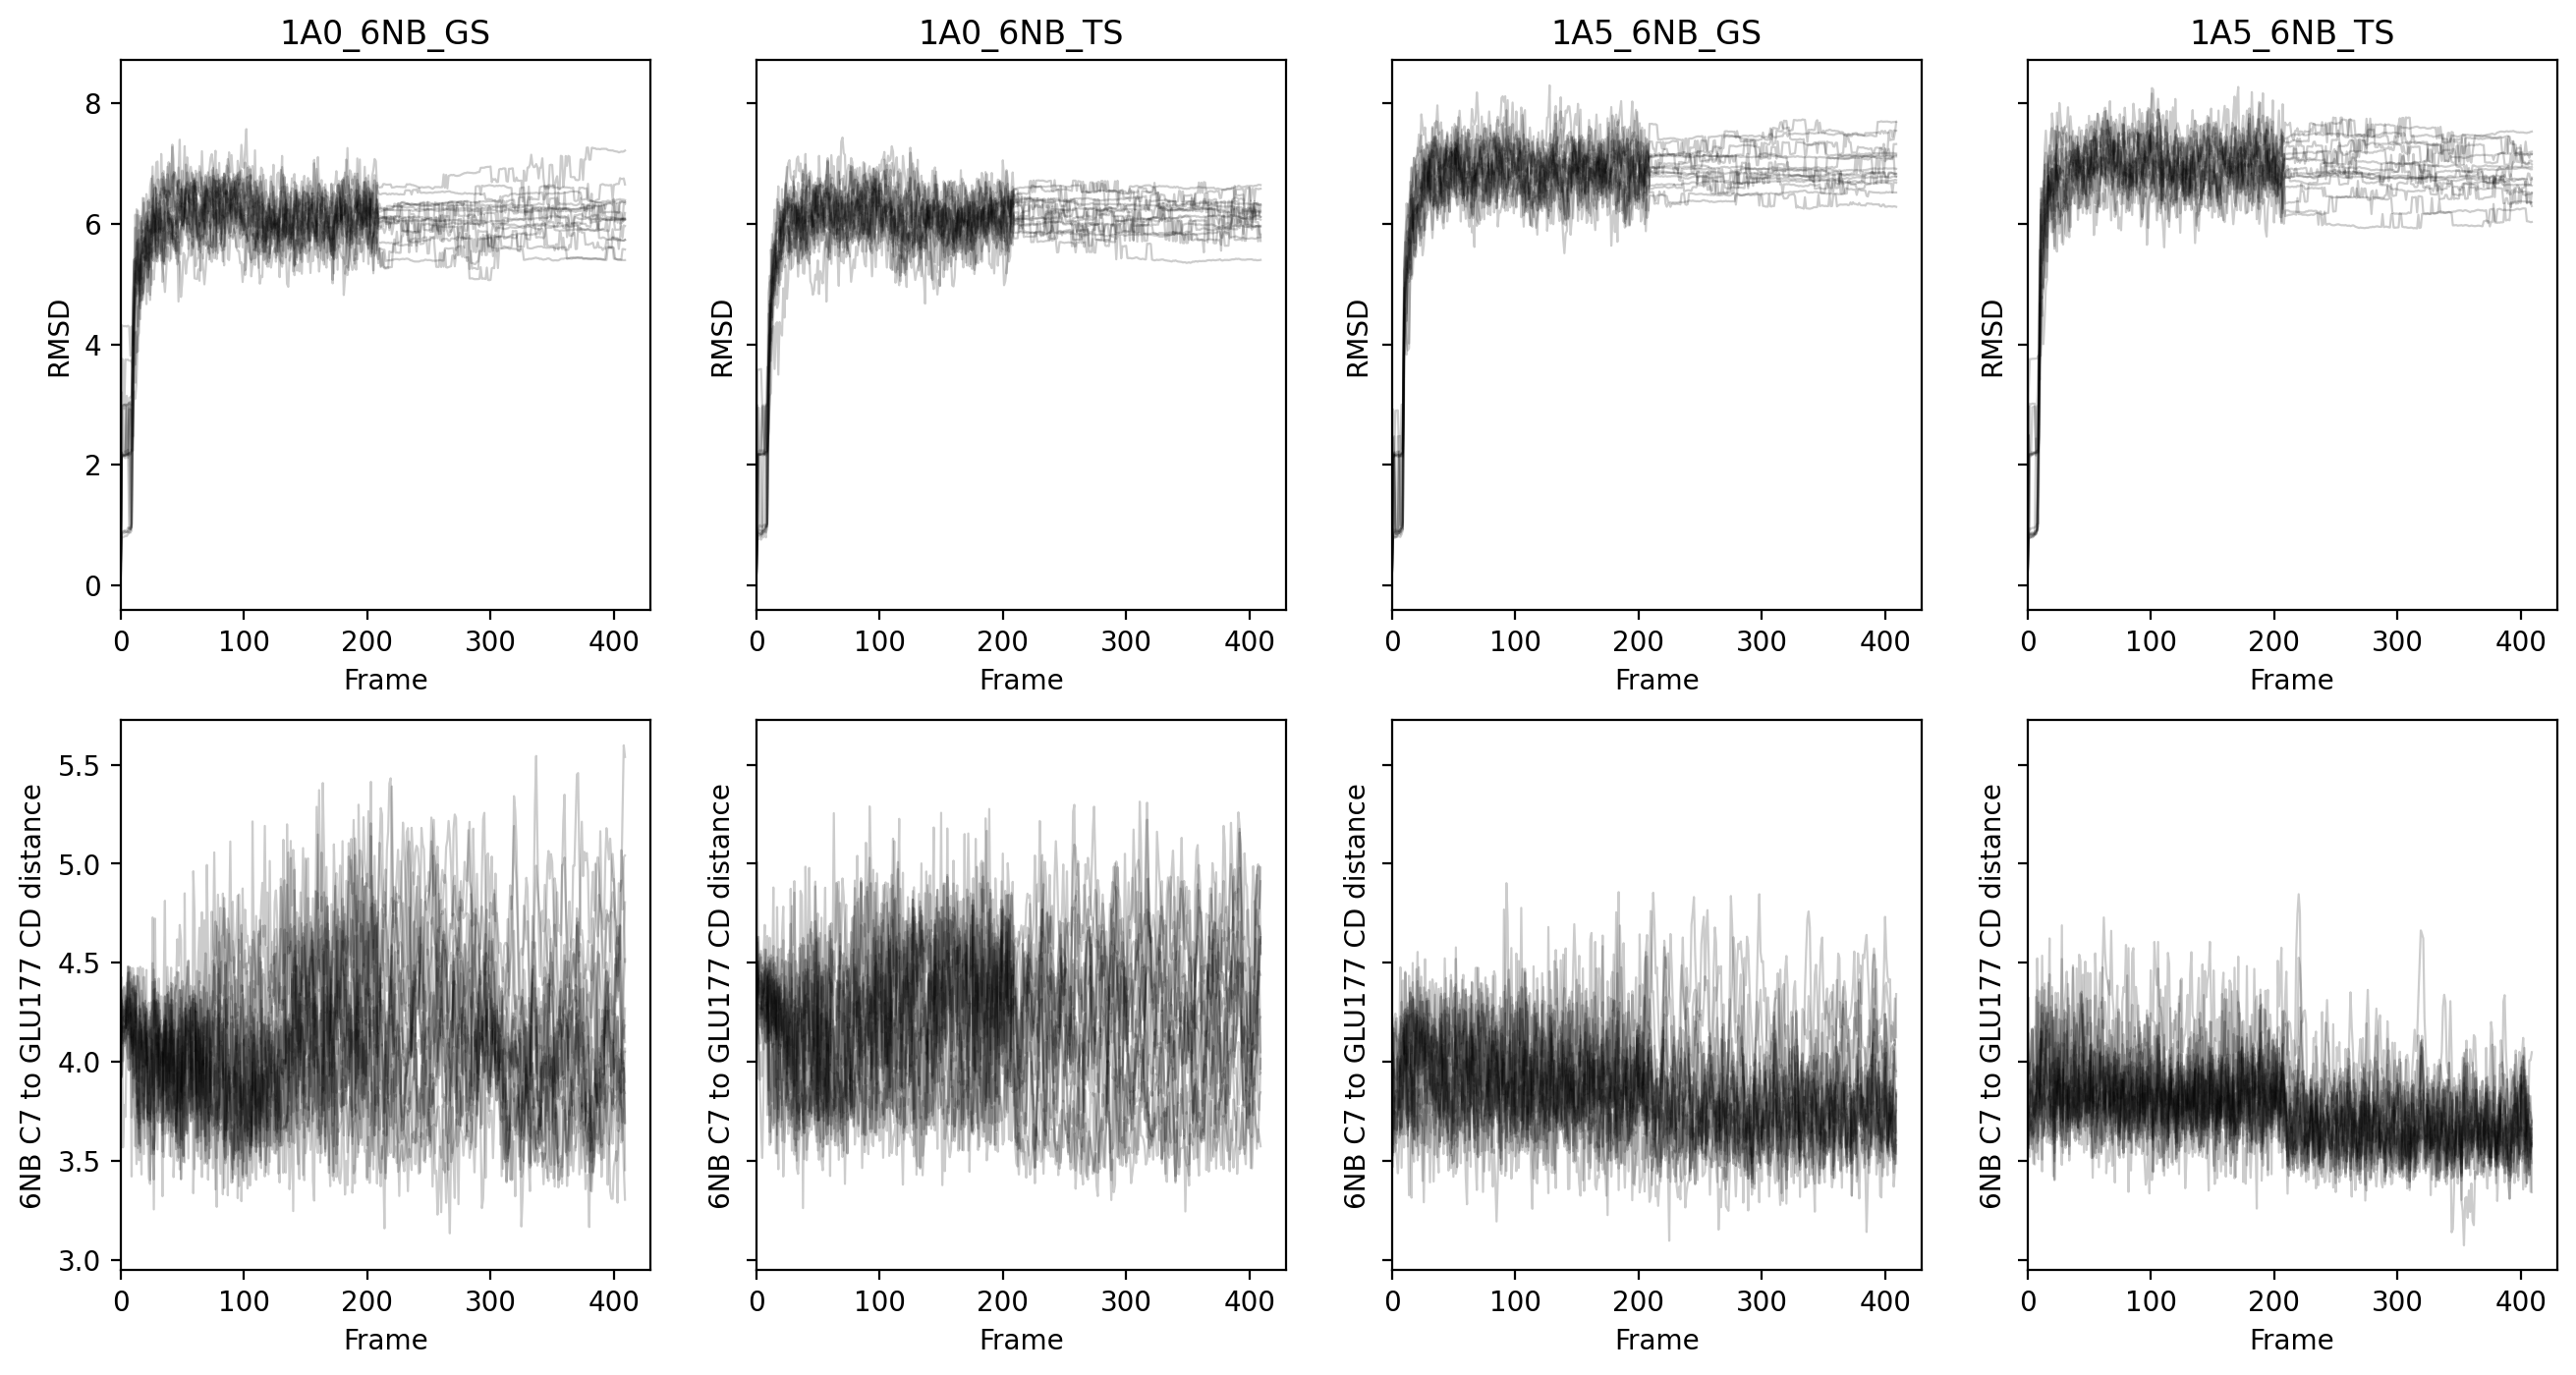

In [91]:
#EXAMPLE 5 from powerpoint
#plotting RMSD with pytraj - saves data as files, only do this once
fig, axs = plt.subplots(2,4, figsize=(16,8), sharey='row')
for fig_col, structure in enumerate(STRUCTURES):

    for index in range(1, N_REPLICATES+1):
        input_folder = f'{FOLDER_EQ}/{structure}/{structure}_{index}/{structure}_{index}'
        
        traj = pt.load([f'{input_folder}_heat.nc',f'{input_folder}_eq_NVT.nc', f'{input_folder}_eq_NPT.nc',f'{input_folder}_eq_QM.nc'],
            top=f'{FOLDER_PA}/{structure}.parm7')

        traj = traj.autoimage()
        traj = pt.center(traj, '!:WAT,POT,CLA,248', mass=True, center='origin')

        rmsd_data = pt.rmsd(traj, mask='!:WAT,POT,CLA,248' ,mass=True)
        np.savetxt(fname=f"{input_folder}_rmsd.dat", X=rmsd_data)

        ligbase_dist = pt.distance(traj, mask=':177@CD :248@C15')
        np.savetxt(fname=f"{input_folder}_ligbasedist.dat", X=ligbase_dist)
        
        axs[0,fig_col].plot(rmsd_data, linewidth=0.8, label=index, color='k', alpha=0.2)
        axs[1,fig_col].plot(ligbase_dist, linewidth=0.8, label=index, color='k', alpha=0.2)

    axs[0,fig_col].set_xlabel('Frame')
    axs[0,fig_col].set_ylabel('RMSD')
    axs[0,fig_col].set_title(f'{structure}')
    axs[0,fig_col].set_xlim(xmin=0)
    axs[0,fig_col].set_xlim(xmin=0)
    axs[1,fig_col].set_xlabel('Frame')
    axs[1,fig_col].set_ylabel('6NB C to GLU177 CD distance')

    axs[1,fig_col].set_xlim(xmin=0)


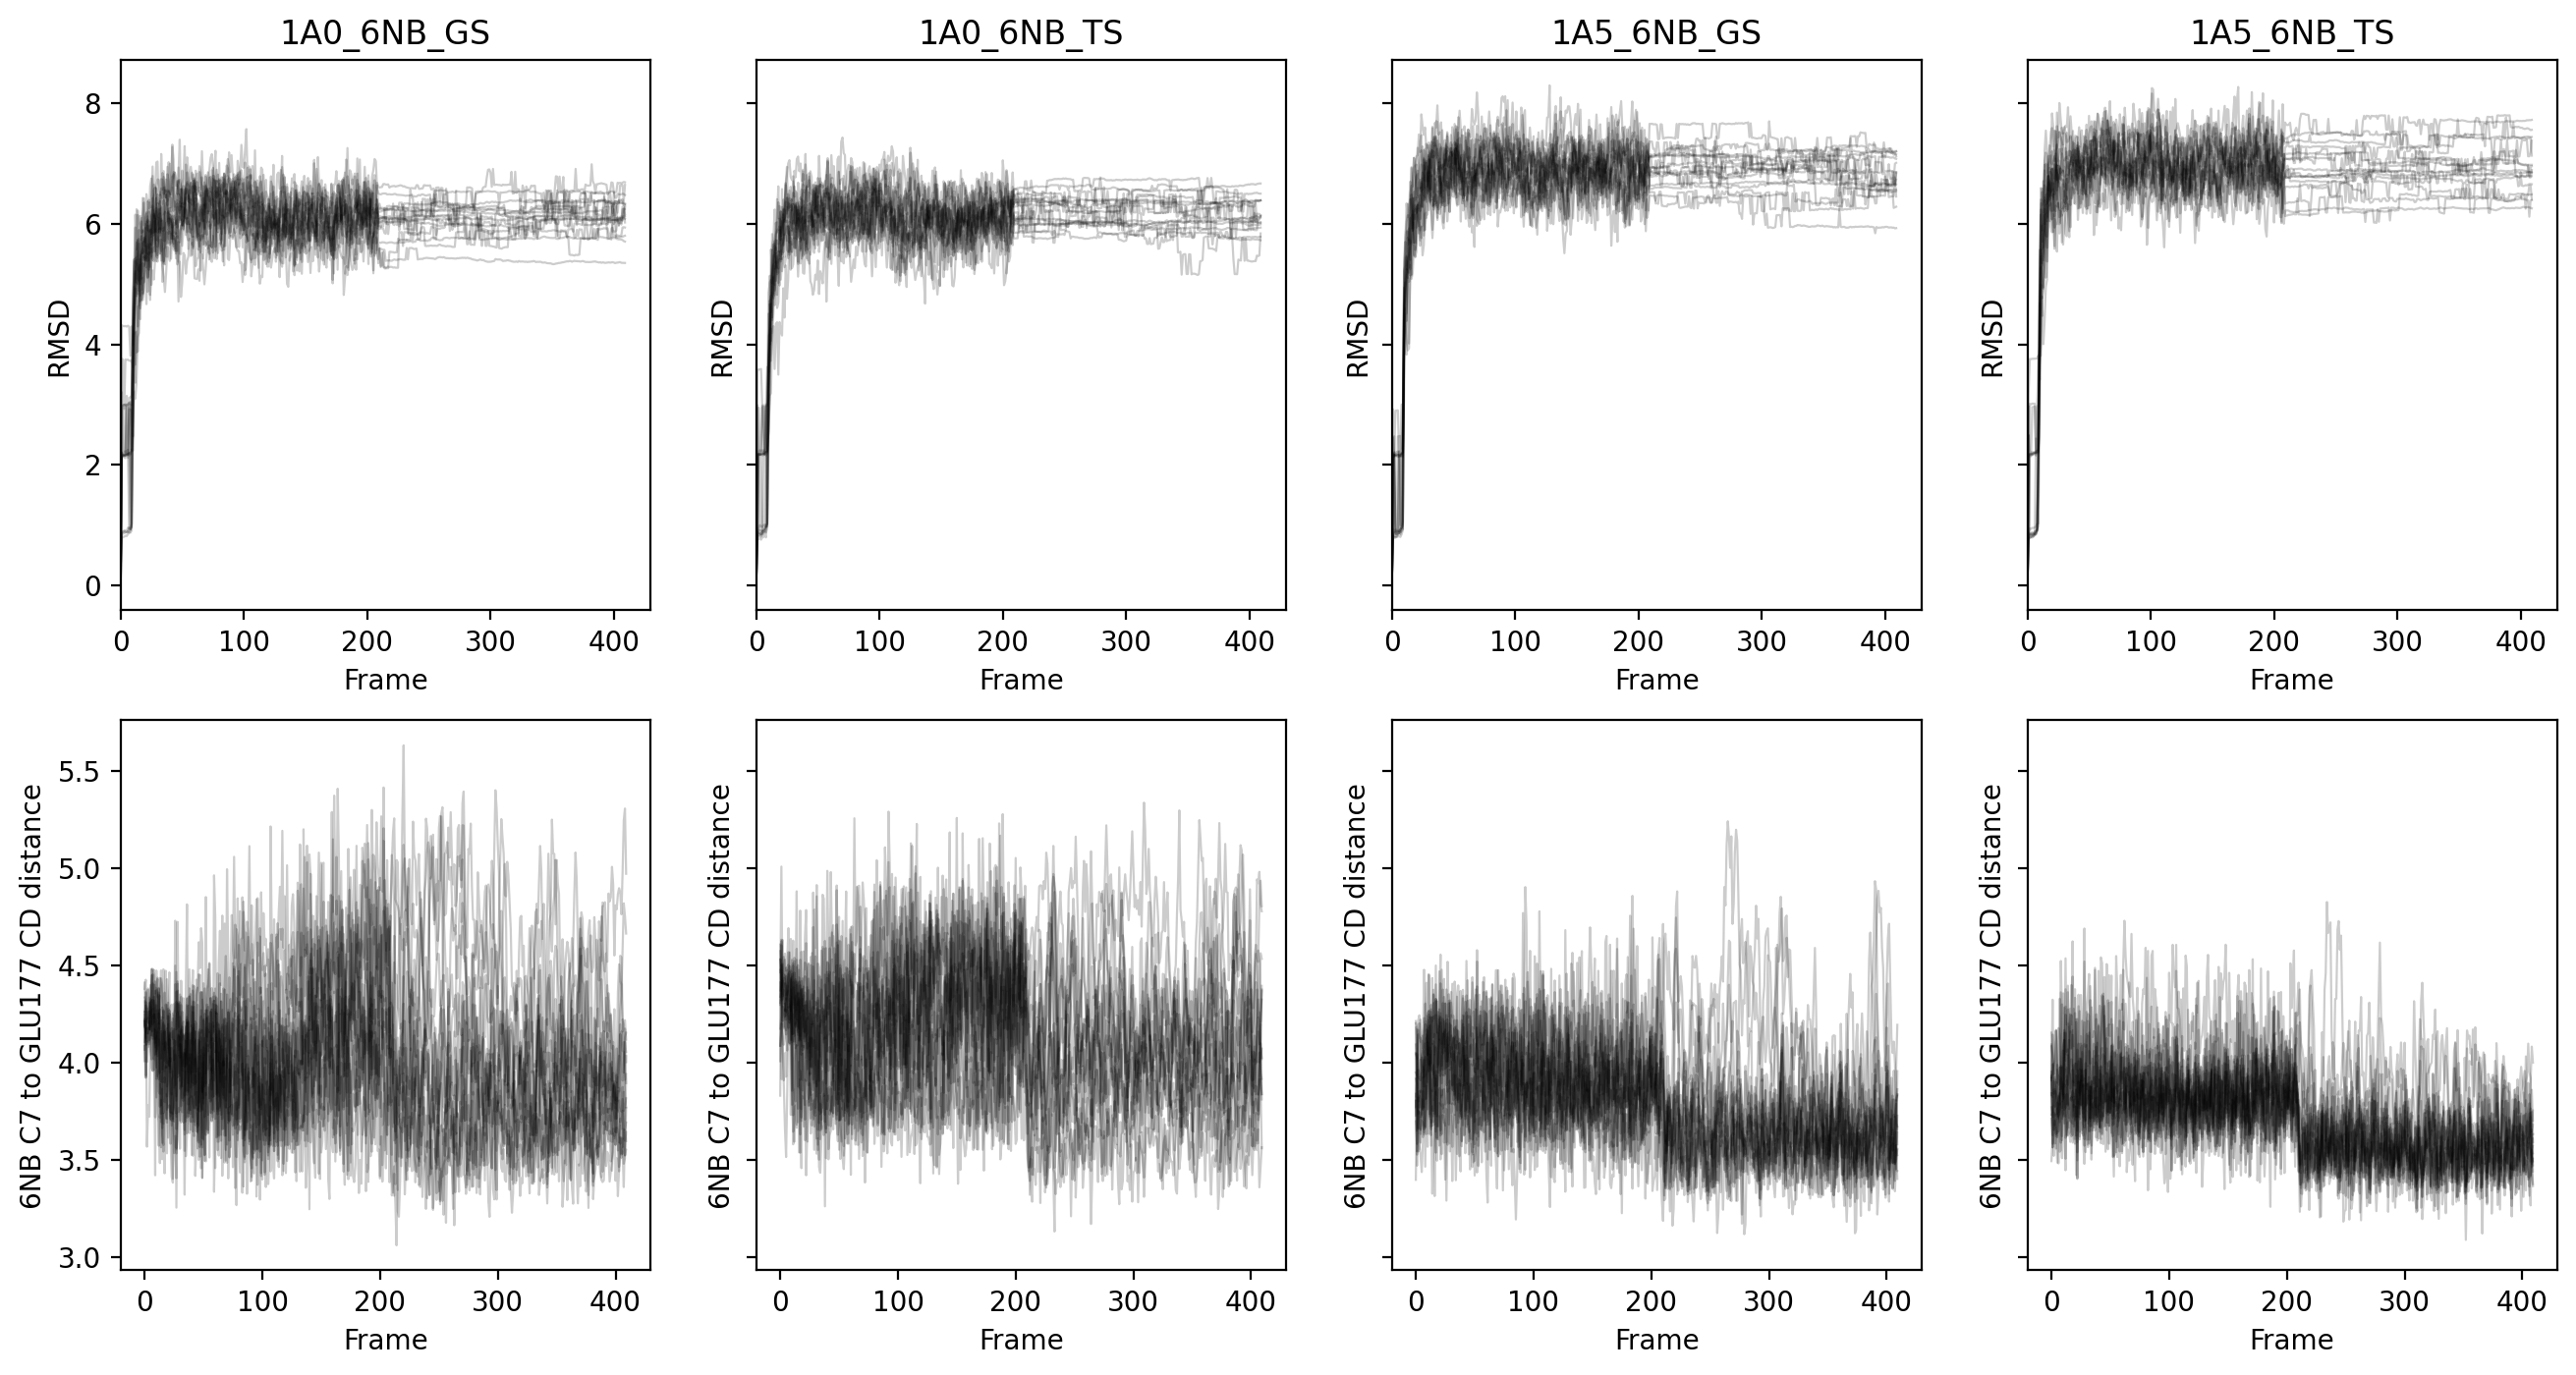

In [31]:
# plots rmsd and ligbase dist data saved to files

fig, axs = plt.subplots(2,4, figsize=(16,8), sharey='row')
for fig_col, structure in enumerate(STRUCTURES):

    for index in range(1, N_REPLICATES+1):
        input_folder = f'{FOLDER_EQ}/{structure}/{structure}_{index}/{structure}_{index}'
        
        try:
            ligbase_dist = np.loadtxt(fname=f"{input_folder}_ligbasedist.dat")
            rmsd_data = np.loadtxt(fname=f"{input_folder}_rmsd.dat")
        except(FileNotFoundError):
            ligbase_dist = [np.nan]
            rmsd_data = [np.nan]
            print(f'file {input_folder}_ligbasedist.dat not found')

        if max(ligbase_dist) > 15:
            color = 'r'
            print(f"{structure}_{index} Ligand moved away from active site")
        elif len(rmsd_data) < 410:
            print(f"{structure}_{index} did not finish")
            color = 'g'
        else:
            color = 'k'
        
        axs[0,fig_col].plot(rmsd_data, linewidth=0.8, label=index, color=color, alpha=0.2)
        axs[1,fig_col].plot(ligbase_dist, linewidth=0.8, label=index, color=color, alpha=0.2)

    axs[0,fig_col].set_xlabel('Frame')
    axs[0,fig_col].set_ylabel('RMSD')
    axs[0,fig_col].set_title(f'{structure}')
    axs[0,fig_col].set_xlim(xmin=0)
    axs[1,fig_col].set_xlabel('Frame')
    axs[1,fig_col].set_ylabel('6NB C7 to GLU177 CD distance')


In [96]:
#Calculates and writes values of CVs to .guess file - check this to get the interpolated guess file for extremes
for structure in ["1A5_6NB_GS", "1A5_6NB_TS"]:
    traj = pt.load(f'{FOLDER_EQ}/{structure}_16_last_eq_QM.pdb')

    CH_bonds = pt.distance(traj, mask=':248@C15 :248@H4') 
    NO_bonds = pt.distance(traj, mask=':248@N14 :248@O16')
    CCN_angles = pt.angle(traj, mask=':248@C12 :248@C15 :248@N14')
    guess = np.stack((CH_bonds, NO_bonds, CCN_angles), axis=1)
    print(guess)

    np.savetxt(f"{FOLDER_ST}/{structure}.guess", X=guess)

[[  1.12108296   1.37513817 108.79537366]
 [  1.12569889   1.3207142  108.47729052]
 [  1.12786967   1.38188024 110.07801325]
 ...
 [  1.13883537   1.35653456 110.93272759]
 [  1.10840065   1.38196563 110.09031718]
 [  1.10640228   1.3533259  110.99895136]]
[[  1.07127868   1.35397415 107.79438286]
 [  1.07565468   1.34869752 108.05333795]
 [  1.08770952   1.36603404 105.84129054]
 ...
 [  1.09988454   1.35289357 110.05255293]
 [  1.08806296   1.34493569 108.59950815]
 [  1.12415168   1.39909792 109.21887889]]


# 2 String method

In [3]:
#Guess files from 1a5_st_equil string equilibration for different QM methods
def get_guess_file(string_folder):
    guess_contents = []
    guess_contents.append("32\n")
    with open(f'{string_folder}/1a5_st_equil/results/0_final_CV.string') as f:
        for line in f:
            CV,values  = line.split(maxsplit=1)
            guess_contents.append(values)
    return "".join(guess_contents)

In [8]:
##Writes all the input files needed for the string method. Automatically sets up for 10 replicates with the endpoints of the previous string used as inputs for the next
N_REPLICATES_ST = 32
STRUCTURES_ST = ["1A0_6NB", "1A5_6NB"]
for structure in STRUCTURES_ST:
    filename = f"{FOLDER_ST}/{structure}/"
    print(filename)

    try:
        os.mkdir(f"{filename}")
    except FileExistsError:
        pass

    shutil.copyfile(f"{FOLDER_PA}/{structure}_GS.parm7", f"{filename}/{structure}_GS.parm7")
    shutil.copyfile(f"{FOLDER_PA}/{structure}_TS.parm7", f"{filename}/{structure}_TS.parm7")

    try:
        guess_contents = get_guess_file(FOLDER_ST)
    except FileNotFoundError:
        print(f'{FOLDER_ST}/1a5_st_equil/results/0_final_CV.string not found, using 2 point guess')  
        #old guess from inspection 
        guess_contents = """2
0.10500E+01    0.13500E+01    0.10000E+03 
0.28000E+01    0.30000E+01    0.16000E+03
"""

    with open(f"{filename}guess", "w") as f:
        f.writelines(guess_contents+"\n")
            
#make collective variables 
    CVs_contents = """BOND :248@C15 :248@H4
BOND :248@N14 :248@O16
ANGLE :248@C12 :248@C15 :248@N14"""      

    with open(f"{filename}cvs.def", "w") as f:
        f.writelines(CVs_contents)    

    MDin_contents = f"""Production 45 ps, save every 0.5 ps, 25 ps production, 50 production snapshots
&cntrl     
    imin           = 0,       !do MD                                                       
    irest = 1, ntx = 5,       !no restart 
    ntpr           = 100,     !save energy ever n steps 
    ntwx           = 500,     !save coordinates ever n steps 
    ntwr           = 100,     !save restrt file ever n steps 
    nstlim         = 45000,   !number steps 10 ps+10 ps string opt 25 ps production  
    dt             = 0.001,   !stepsize in ps 
    ioutfm         = 1,       !Binary output faster 
    iwrap          = 1,       !Put Atoms back into Box                   
    ntt            = 2        !Andersen thermostate                       
    tempi          = 300,     !initial temp 
    temp0          = 300,     !target temp 
    ntp            = 1,       !pressure                                     
    ntc = 1, ntf   = 1,       !no shake          
    cut            = 8,       !e. static cutoff 
    ntb            = 2,       !constant pressure
    nmropt         = 1,       !Restraints  
    ifqnt          = 1,       !Switch on QM/MM coupled potential
&end 
&qmmm 
    qmmask = '{qmmask}', 
    qmcharge = -1, 
    spin = 1, 
    qm_theory = '{QMMM_method}',
    qmshake = 0,
    qmcut = 8.0,
    !itrmax = 1000000,
    printcharges = 1, 
    dftb_telec=100
&end
&wt TYPE='END' /
"""
##DISANG=../"""+STRUCTURE+"""_DISANG_STRING.rst  
     
    with open(f"{filename}md.in", "w") as f:
        f.writelines(MDin_contents)    

    #for index_st in range(1,2):
    for index_st in range(1,2): ###set INDEX to max 10 ... adjust everywhere
        try:
            os.mkdir(f"{FOLDER_ST}/{structure}/{index_st}")
            os.mkdir(f"{FOLDER_ST}/{structure}/{index_st}/results")
        except FileExistsError:
            pass   

        filename = f"{FOLDER_ST}/{structure}/{str(index_st)}/"

        #requires generate_cvs.py script from github https://github.com/kzinovjev/string-amber/blob/0252c75415aa5ae9a91d54a6d2f3882af003aeeb/utils/generate_cvs.py in the same folder as notebook
        
        os.system(f"python generate_cvs.py {FOLDER_ST}/{structure}/{structure}_GS.parm7 {FOLDER_ST}/{structure}/cvs.def > {filename}CVs")    
        
        #writing string setup
        forceconstant_guess = "100" 

        #writing stopstring
        with open(f"{filename}STRING", "w") as f:
            f.writelines(f""""$STRINGSETUP
dir = "results/"
guess_file = "../guess"
force_constant = {forceconstant_guess}.0
remove_z_bias = .false.
$END       
""")
                             
        with open(f"{filename}results/STOP_STRING", "w") as f:
            f.writelines("""10000\n20000\n""")  

        #writing groupfile
        for input_idx in range(1,N_REPLICATES_ST+1):
            if input_idx <= 16: #filename_in path to GS structures
                parm_fpath = f"{structure}_GS"                
            else: #change filename_in path to TS structures 
                parm_fpath = f"{structure}_TS"
            
            with open(f"{filename}string.groupfile", "a") as f:
                f.writelines(f"-O -rem 0 -i ../md.in -o {input_idx}.out \
                -c {input_idx}_input.rst7 -r {input_idx}.rst7 -x {input_idx}.nc -inf {input_idx}.mdinfo \
                -p ../{parm_fpath}.parm7 \n") 
                        
## writing cpptraj.in for inputs - using equilibrated structures (INDEX = 1)

        if index_st == 1:
            for input_idx in range(1,N_REPLICATES_ST+1,1):

                #temp = [f"parm {FOLDER_ST}/{structure}/{structure}.parm7"]
                if input_idx <= 16: #filename_in path to GS structures
                    filename_in = f"{FOLDER_EQ}/{structure}_GS/{structure}_GS_{input_idx}/{structure}_GS_{input_idx}_eq_QM.rst7"
                    parm_fpath = f"{FOLDER_PA}/{structure}_GS.parm7"
                else: #change filename_in path to TS structures 
                    filename_in = f"{FOLDER_EQ}/{structure}_TS/{structure}_TS_{input_idx-16}/{structure}_TS_{input_idx-16}_eq_QM.rst7"
                    parm_fpath = f"{FOLDER_PA}/{structure}_TS.parm7"

                # if structure == "1A5_6NB" and QMMM_method == 'DFTB3': #shuffle inputs for string 1 for 1A5 else it gets hung up
                #     shuffled_nodes = [7,2,13,12,6,11,4,16,14,3,5,15,9,1,10,8,32,22,26,30,27,24,31,20,28,25,21,23,19,18,17,29]
                #     output_filepath = f"{filename}/{shuffled_nodes[input_idx-1]}_input"
                # else:
                output_filepath = f"{filename}/{input_idx}_input"
                
                with open("cpptraj.in", "w") as f:
                    f.write(f"parm {parm_fpath}\n")    
                    if os.path.isfile(filename_in): 
                        f.write(f"trajin {filename_in}\n")    
                    else:
                        (print(f"{filename_in} file not found"))
                    f.write("autoimage\n")
                    f.write(f"outtraj {output_filepath}.rst7\n")

                # with open("cpptraj.in", "w") as f:
                #     f.write("\n".join(temp))  

                os.system("cpptraj -i cpptraj.in >2")

        #!cp "$FOLDER_ST"/"$STRUCTURE"/CVs                       "$filename"/CVs

2_String_example/1A0_6NB/
2_String_example/1a5_st_equil/results/0_final_CV.string not found, using 2 point guess
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_1/1A0_6NB_GS_1_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_2/1A0_6NB_GS_2_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_3/1A0_6NB_GS_3_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_4/1A0_6NB_GS_4_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_5/1A0_6NB_GS_5_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_6/1A0_6NB_GS_6_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_7/1A0_6NB_GS_7_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_8/1A0_6NB_GS_8_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_9/1A0_6NB_GS_9_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A0_6NB_GS_10/1A0_6NB_GS_10_eq_QM.rst7 file not found
1_Equilibrate_example/1A0_6NB_GS/1A

In [28]:
#defining a function to run string calculation
def runjob_string(structure,string_folder,N_REPLICATES=N_REPLICATES_ST,INDEX_MAX=11):

    with open("MD.sh", "w") as f:    
        f.write(f"""#!/bin/bash
#SBATCH --partition mwvdk  
#SBATCH --job-name=S_{structure}_{QMMM_method}
#SBATCH -o         S_{structure}_{QMMM_method}
#SBATCH --time=3-00:00:00    # Walltime
#SBATCH --nodes=2             # number of tasks
#SBATCH --ntasks-per-node=16  # number of tasks per node
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=10G 
#SBATCH --account=ptch000721

#module load lang/intel-parallel-studio-xe/2020
module add lib/openmpi/4.0.2-gcc

export I_MPI_COMPATIBILITY=3

cd {os.getcwd()}/{string_folder}/{structure}
pwd

source /user/home/hb18661/amber20/amber.sh
#module load apps/amber/20

echo AMBERHOME: \$AMBERHOME \n

module list
which sander
        """)

        for index in range(1,INDEX_MAX+1,1):
        
            #check to see if the string iteration is already done    
            if not os.path.isfile(f"{string_folder}/{structure}/{str(index)}/1.rst7"): 
                print (f"{string_folder}/{structure}/{str(index)}/1.rst7","missing")
                # add run string calc to input script
                f.write(f"cd {os.getcwd()}/{string_folder}/{structure}/{str(index)}\n")
                f.write(f"echo starting string {index}\n")
                f.write(f"srun -n 32 --cpu-bind=cores --mpi=pmix_v3 sander.MPI -ng {N_REPLICATES_ST} -groupfile string.groupfile\n")

            else:
                print(f"{string_folder}/{structure}/{str(index)}/1.rst7","already done")
                
            f.write(f"""\necho {structure}_{str(index)} done \n""")
            
            #break the loop if the index has reached 11
            if index == INDEX_MAX: 
                continue
            
            f.write(f"""\ncd {os.getcwd()}\n""")
            
            #if the inputs aren't in the next folder, do the cpptraj copy paste
            if not os.path.isfile(f"{string_folder}/{structure}/{str(index+1)}/1_input.rst7"): 

                for node_idx in range(1,N_REPLICATES+1,1):
                    if node_idx <= 16: #topology file path to GS structures
                        parm_fpath = f"{FOLDER_ST}/{structure}/{structure}_GS"                
                    else: #topology file path path to TS structures 
                        parm_fpath = f"{FOLDER_ST}/{structure}/{structure}_TS"

                    input_filepath = f"{FOLDER_ST}/{structure}/{index}/{node_idx}"
                    output_filepath = f"{FOLDER_ST}/{structure}/{index+1}/{node_idx}_input"

                    f.write(f"""cpptraj -p {parm_fpath}.parm7 -i cpptraj_autoimage.in -y {input_filepath}.rst7 -x {output_filepath}.rst7\n""")       

    os.system("sbatch MD.sh")

In [29]:
STRUCTURES_ST=["1A0_6NB","1A5_6NB"] 
for structure in STRUCTURES_ST:
  runjob_string(structure=structure,string_folder=FOLDER_ST,N_REPLICATES=N_REPLICATES_ST, INDEX_MAX=1) 

2_String_CHARMM_natchem_DFTB3/1A5_6NB/1/1.rst7 missing
Submitted batch job 4618708


1A5_6NB
201


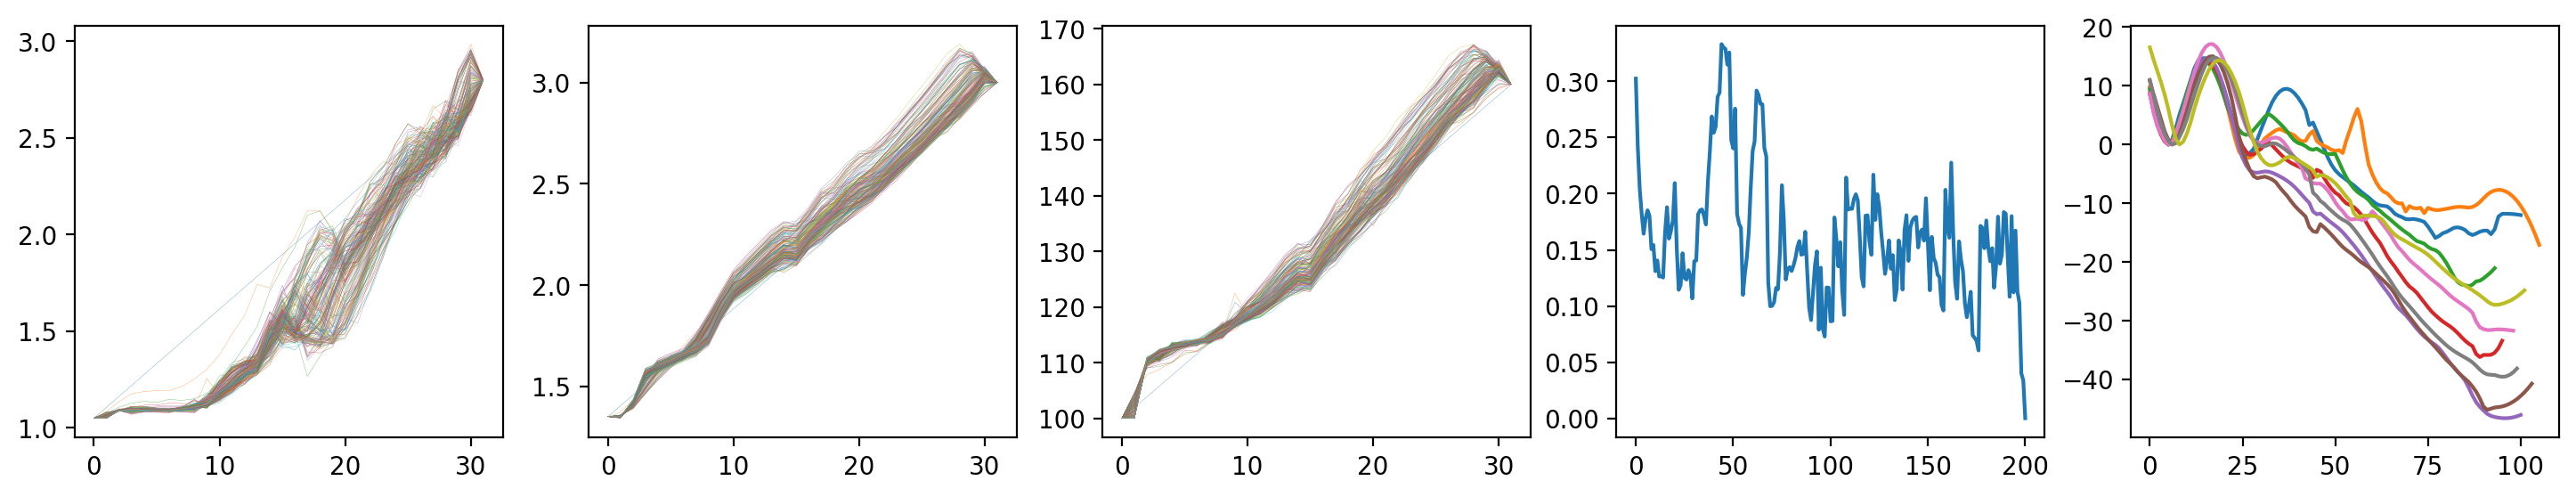

In [56]:
#Quality control for convergence - not very well written
string_folder = FOLDER_ST
string_index = 1

for structure in STRUCTURES_ST:
    #continue
    print(structure)
    plt.rcParams["figure.figsize"] = [18,3]
    fig, axs = plt.subplots(1,5)  
    test = -1

## this loop plots values of CVs against reaction coordinates as string converges 
    for index in range(0,20000,100):
        filename=f"{string_folder}/{structure}/{string_index}/results/{index}"
        if os.path.isfile(f"{filename}.string"):
            test = test+1
            with open(f"{filename}.string") as f:
                data = f.readlines()
            data = [[float(j) for j in i.split()] for i in data]
            x = range(0,len(data),1)

            for CV_index in range(0,len(data[0]),1):
                axs[CV_index].plot(x,[i[CV_index] for i in data],linewidth=0.1)
                axs[CV_index].set_title(f"CV {CV_index}")

## this loop prints convergence of string 1
    if os.path.isfile(f"{string_folder}/{structure}/{string_index}/results/convergence.dat"):
        with open(f"{string_folder}/{structure}/{string_index}/results/convergence.dat") as f:
            data = [float(i.split()[-1]) for i in f.readlines()]
        x = range(0,len(data),1)
        print (len(data))
        axs[-2].plot(x,data)
        axs[-2].set_title("Convergence")
        
## this loop prints PMFs every 2000 steps of the first 20000 steps of string 1
    for INDEX in range(0,20000,2000):
        filename=f"{string_folder}/{structure}/{string_index}/results/{str(INDEX)}"
        if os.path.isfile(filename+".PMF"):
            with open(filename+".PMF") as f:
                data = [i.split() for i in f.readlines()[2:]]
            #break
            x = range(0,len(data),1)
            axs[-1].plot(x,[float(i[-2]) for i in data])
            axs[-1].set_title("PMFs")
            # axs[-1].set_ylim(0,30)
            # axs[-1].set_xlim(0,50)
    plt.show()